In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from itertools import chain

def sparseRange(n: int)->chain:
    if n < 1: raise Exception("Invalid Argument")
    sparse_range = range(0)
    for i in range(n):
        sparse_range = chain(sparse_range, range(10**i,10**(i+1),10**i))
    return sparse_range

In [2]:
MNISTmini = sio.loadmat('MNISTmini.mat')
digits = [4,9]
validationRatio = .9

In [26]:
# load feature and class vectors from MNISTmini
trainFea = MNISTmini['train_fea1']
trainClass = MNISTmini['train_gnd1']
testFea = MNISTmini['test_fea1']
testClass = MNISTmini['test_gnd1']

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [4]:
# crop data to include only digits from digits list
includes = list(map(lambda x: x in digits, trainClass))
trainFea = trainFea[includes]
trainClass = trainClass[includes]
includes = list(map(lambda x: x in digits, testClass))
testFea = testFea[includes]
testClass = testClass[includes]

In [29]:
# shuffle and crop data to include random points
trainTotal = trainFea.shape[0]
trainSize = int((1-validationRatio)*trainTotal)

trainFeaShuffled, trainClassShuffled = shuffle(trainFea, trainClass, random_state=0)

trainFea = trainFeaShuffled[0:trainSize]
trainClass = trainClassShuffled[0:trainSize]
validationFea = trainFeaShuffled[trainSize:trainTotal]
validationClass = trainClassShuffled[trainSize:trainTotal]

testFea, testClass = shuffle(testFea, testClass, random_state=0)
testFea, testClass = testFea[0:1000], testClass[0:1000]

[[4]
 [7]
 [4]
 [8]
 [1]
 [3]
 [9]
 [3]
 [7]
 [7]]


In [6]:
linearRegressors:list[LogisticRegression] = []

for i in sparseRange(7):
    linearRegressors.append(LogisticRegression(
        penalty='l2',
        dual=False,
#         tol=1e-5,
        C=i*1e-8,
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=None,
        solver='liblinear',
        max_iter= 100,
        multi_class='auto',
        verbose=0,
        warm_start=False,
        n_jobs=None,
        l1_ratio=None
    ))

In [7]:
for model in linearRegressors:
    model.fit(trainFea, trainClass.ravel())

In [8]:
def complexity(model:LogisticRegression):
    if model.get_params()["penalty"] == 'l1':
          return np.sum(np.abs(model.coef_))
    return np.sum(np.square(model.coef_))

complexityLabels: list[float]  = []
trainError: list[float] = []
valiError: list[float] = []

for model in linearRegressors:
    complexityLabels.append(complexity(model))
    trainError.append(1-model.score(trainFea, trainClass))
    valiError.append(1-model.score(validationFea, validationClass))

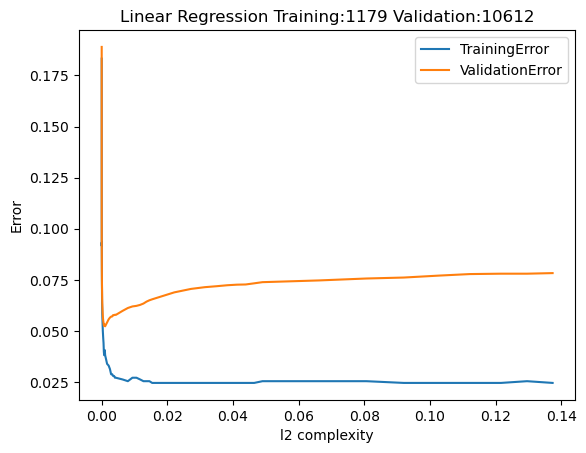

In [116]:
plt.title(f'Linear Regression Training:{trainSize} Validation:{trainTotal-trainSize}')
plt.xlabel(f'{linearRegressors[0].get_params()["penalty"]} complexity')
plt.ylabel('Error')

plt.plot(complexityLabels, trainError, label="Training Error")
plt.plot(complexityLabels, valiError, label="Validation Error")
plt.legend(['TrainingError','ValidationError'], loc='upper right')

plt.show()

In [101]:
treeEnsembles: list[RandomForestClassifier] = []

for i in sparseRange(3):
    treeEnsembles.append(RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='sqrt',
        max_leaf_nodes=i*2,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None
))

In [102]:
for model in treeEnsembles:
    model.fit(trainFea, trainClass.ravel())

In [103]:
def complexity(model:RandomForestClassifier):
    return model.get_params()['max_leaf_nodes']

complexityLabels: list[float]  = []
trainError: list[float] = []
valiError: list[float] = []

for model in treeEnsembles:
    complexityLabels.append(complexity(model))
    trainError.append(1-model.score(trainFea, trainClass))
    valiError.append(1-model.score(validationFea, validationClass))

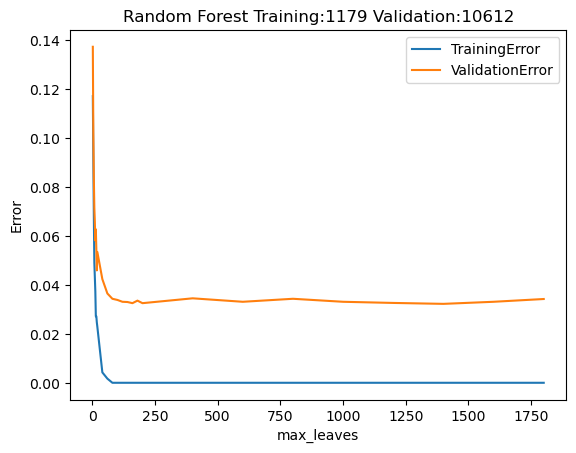

In [104]:
plt.title(f'Random Forest Training:{trainSize} Validation:{trainTotal-trainSize}')
plt.xlabel(f'max_leaves')
plt.ylabel('Error')

plt.plot(complexityLabels, trainError, label="Training Error")
plt.plot(complexityLabels, valiError, label="Validation Error")
plt.legend(['TrainingError','ValidationError'], loc='upper right')

plt.show()